# IMPORTS

In [496]:
# all the relevant imports are done here
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys
basedir = 'C:\\Users\\rpetr\\OneDrive\\Desktop\\DISS_CODE\\ms2ldaviz\\ms2ldaviz'
sys.path.append(basedir)
import django
import json
django.setup()
from basicviz.models import Experiment, Alpha, Mass2MotifInstance, FeatureInstance, Feature, Document, Mass2Motif, DocumentMass2Motif, FeatureMass2MotifInstance
import numpy as np
import pylab as plt
import csv
from scipy.special import polygamma as pg
from scipy.special import psi as psi

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# VARIABLES

###### Choose an experiment. In this case it is experiment 190. It has 500 topics, 27923 words and 2132 unique docs. These were tested against the database using appropriate queries. 

In [497]:
experiment_id=190 
experiment = Experiment.objects.get(id=experiment_id)
min_prob_beta = 1e-3
SMALL_NUMBER = 1e-100
eta = 0.1 #needed for beta m-step

# CORPUS (features for 1 document in experiment 190)

###### First we get all features in the database for our experiment. 

In [498]:
# Get all features in the database relevant for our experiment. 
features = Feature.objects.filter(experiment_id=experiment)
experiment_words = []
for f in features:
     if f.id not in experiment_words: 
        experiment_words.append(f.id)

In [499]:
# Unique words lists all the features as {feature_id:incremental_id} word value pairs. 
unique_words = {}
index = 0
for word in experiment_words:
    if word not in unique_words.keys():
        unique_words.update({word:index})
        index+=1

###### Then we get a random document for our experiment from the database. 

In [500]:
#We will use a single document for our experiment. Modify here if more documents are needed. 
experiment_docs=[269485]

In [501]:
#unique documents is the dictionary -> doc: id 
unique_docs = {}
index = 0 
for doc in experiment_docs: 
    unique_docs.update({doc:index})
    index+=1

###### Get the features only for the specific documents and create the corpus dictionary {DOC:{WORD:COUNT}}. 

In [502]:
# Get features for all documents chosen. The output columns are doc_id, word_id and intensity.
feature_instances = FeatureInstance.objects.filter(document_id__in=unique_docs.keys(), feature_id__in=unique_words.keys())
doc_word_data = []
for f in feature_instances:
    doc_word_data.append([unique_docs[int(f.document_id)], unique_words[int(f.feature_id)], f.intensity])

In [505]:
# Output a csv for the corpus in order to create a dictionary made up of {document_id:{word_id:intensity}}. 
# Intensity in this case is an integer (count).
doc_word_array = np.array(doc_word_data)
np.savetxt("corpus_data.csv", doc_word_array, delimiter=",", fmt="%s")
np.save("corpus_data",doc_word_array)

In [506]:
# CREATE THE CORPUS - a dictionary where key is document id and value is a dict of the count of words
# You might need to change the csv output above (for now, by adding an extra row with doc_id, word_id, count)
corpus_dict = {}
with open("corpus_data.csv", 'r') as data_file:
    data = csv.DictReader(data_file, delimiter=",")
    for row in data:
        item = corpus_dict.get(row["doc_id"], dict())
        item[row["word_id"]] = int(row["count"])
        corpus_dict[row["doc_id"]] = item
#Get the corpus dict whenever this is necessary

# UNIQUE TOPICS

In [507]:
# Get the 500 unique topics for the experiment. 
mi = Mass2Motif.objects.filter(experiment=experiment)
unique_topics = {}
index=0
for m in mi: 
    unique_topics.update({m.id:index})
    index+=1

# ALPHA

In [508]:
# Get Alphas from database, transferm to numpy vector. 
al = Alpha.objects.filter(mass2motif__experiment=experiment).order_by('mass2motif')
alphas = {}
for a in al:
    alphas.update({unique_topics[a.mass2motif_id]: a.value})
n_motif = len(alphas)
alpha_vec = np.zeros(n_motif)
for pos,val in alphas.items():
    alpha_vec[pos] = val

In [509]:
alpha_vector = alpha_vec

In [ ]:
# save to text if necessary 
# np.savetxt("alpha.csv", alpha_vector, delimiter=",", fmt="%s")

# BETA

In [510]:
# Get beta from the database (it is a topic * words 2d matrix - each cell is a probability)
beta_pre_pivot = []
mi = Mass2MotifInstance.objects.filter(mass2motif__experiment=experiment)
for m in mi:
    beta_pre_pivot.append([unique_topics[m.mass2motif_id], unique_words[m.feature_id], m.probability]) 

In [511]:
# Some topics may have 0 words - these have been reincluded 
# Creating array from the beta data and subsequently creating a pivot (matrix)
output_arr_beta = np.array(beta_pre_pivot)
K = len(unique_topics)
W = len(unique_words)
pivot_table = np.zeros((K, W)).astype('float')
i = 0
max = len(beta_pre_pivot)
while i<max:
    pivot_table[int(output_arr_beta[i][0]),int(output_arr_beta[i][1])]=output_arr_beta[i][2]
    i+=1

In [ ]:
# Use this to get beta csv. 
# np.savetxt("beta.csv", pivot_table, delimiter=",")

In [512]:
# Normalise the beta pivot table matrix. 
pivot_table_normalised = pivot_table
i = 0
while i<K: 
    row = pivot_table_normalised[i, :]
    adjusted_row = row + SMALL_NUMBER
    normalised_row = adjusted_row / np.sum(adjusted_row)
    np.sum(normalised_row)
    pivot_table_normalised[i, :] = normalised_row
    i+=1

In [ ]:
# Use this to output a csv for the beta matrix if needed. 
# np.savetxt("beta_matrix.csv", pivot_table_normalised, delimiter=",")

# VISUALISATION

In [ ]:
# use for visualisation if necessary 
# my_dpi=150
# plt.figure(figsize=(2000/my_dpi, 2000/my_dpi), dpi=my_dpi)
# plt.imshow(pivot_table_normalised, aspect="auto")

# GET ORIGINAL THETA(NORM GAMMA)

In [513]:
# get the original theta from the database for subsequent comparison 
# remember theta is just normalised gamma and represents a docs * topics matrix 
theta = DocumentMass2Motif.objects.filter(document_id__in=experiment_docs)
output_data_theta = []
for t in theta:
    output_data_theta.append([unique_docs[int(t.document_id)], unique_topics[int(t.mass2motif_id)], t.probability])

In [514]:
output_data_theta

[[0, 432, 0.0108946743038854],
 [0, 475, 0.0155604811730774],
 [0, 50, 0.956476683498498]]

# GET ORIGINAL PHI 

In [515]:
# get the features related to the instances
feature_instance = FeatureInstance.objects.filter(document_id__in=experiment_docs)
feature_instance_join = {}
for i in feature_instance:
    feature_instance_join.update({int(i.id):[int(i.document_id), int(unique_words[i.feature_id])]})

In [516]:
# connect docs, topics and features into a list of lists
feature_m2m_instance = FeatureMass2MotifInstance.objects.filter(mass2motif__experiment=experiment)
phi_list = []
for i in feature_m2m_instance:
    if i.featureinstance_id in feature_instance_join.keys():
        phi_list.append([feature_instance_join[int(i.featureinstance_id)][0], unique_topics[int(i.mass2motif_id)], feature_instance_join[int(i.featureinstance_id)][1],i.probability])

In [517]:
# This gives the original phi, which in abstract terms is a 3D matrix -> docs * topics * words
phi_original = []
for line in phi_list: 
    phi_original.append([line[0],line[2],line[1],line[3]])
phi_original_array = np.array(phi_original)

In [ ]:
# np.savetxt("phi_original_array.csv", phi_original_array, delimiter=",", fmt="%s")
# np.save("phi_original_array", phi_original_array)

# E-STEP (has 9 steps)

## Step 0 - E-step variables

In [541]:
# alpha_vector is already mentioned above
# beta_matrix is created here from pivot_table_normalised
# K and W are from above for total unique topics, total unique words respectively 
# you need a corpus (created above)
corpus = corpus_dict
beta_matrix = pivot_table_normalised

## Step 1 - Initialise phi matrix

In [542]:
# initialise the 3D matrix phi with zeroes
phi_matrix={}
for doc in corpus: 
    d = int(doc)
    phi_matrix[d] = {}
    for word in corpus[doc]:
        w = int(word)
        phi_matrix[d][w]=np.zeros(K)

## Step 2 - initialise gamma matrix

In [543]:
# create a gamma matrix with rows as documents and columns as topics 
# this will later be transposed in order to create the phi matrix in the steps 3-9 below
# doc_total is the count of words per doc, and each gamma is alpha plus that

gamma_matrix=np.zeros((int(len(corpus)),int(K))) #3x500 shape
for doc in corpus:
    doc_total=0.0
    for word in corpus[doc]:
        doc_total += corpus[doc][word]
    gamma_matrix[int(doc),:] = alpha_vector + 1.0*(doc_total/K)

## Step 3 - 9: repeat until convergence loop

In [544]:
# initialise phi and do Blei's loop (Simon's implementation)
test_list = []
iterations=10000
n_words = int(len(unique_words))
temp_beta = np.zeros((K, n_words))
current_gamma = np.copy(gamma_matrix)
for i in range(iterations):   
    prev_gamma = np.copy(current_gamma)
    for doc in corpus:
        d = int(doc)
        doc_dict = corpus[doc]
        temp_gamma = np.zeros(K) + alpha_vector
        for word in doc_dict:  
            w = int(word)
            log_phi_matrix = np.log(beta_matrix[:,w]) + psi(gamma_matrix[d,:]).T
            log_phi_matrix = np.exp(log_phi_matrix - log_phi_matrix.max())
            phi_matrix[d][w] = log_phi_matrix/log_phi_matrix.sum()
            temp_gamma += phi_matrix[d][w]*corpus[doc][word]
            temp_beta[:,w] += phi_matrix[d][w] * corpus[doc][word]
        gamma_matrix[d,:] = temp_gamma
        pos = np.where(gamma_matrix[d,:]<SMALL_NUMBER)[0]
        gamma_matrix[d,pos] = SMALL_NUMBER
    current_gamma = np.copy(gamma_matrix)
    gamma_diff = ((current_gamma - prev_gamma)**2).sum()
#     beta_matrix = temp_beta
    test_list.append([i, gamma_diff])

In [545]:
# test the output list of the above e-step 
test_list[900:910]

[[900, 2.012226397037757e-26],
 [901, 2.0623979506098133e-26],
 [902, 5.295261011820975e-23],
 [903, 3.335303907274438e-27],
 [904, 4.0421232783524645e-27],
 [905, 3.496231531939524e-27],
 [906, 5.073953342381548e-27],
 [907, 5.970099330712617e-27],
 [908, 7.472090494253424e-27],
 [909, 1.8175355256292112e-27]]

In [ ]:
# get an array output if necessary 
# gamma_diff_array = np.array(test_list)
# np.savetxt("gamma_diff_array.csv", gamma_diff_array, delimiter=",", fmt="%s")

# COMPARISON OF GAMMA & PHI (original vs calculated csv exports) 

## Gamma comparison / actually Theta comparison 

In [546]:
# output_data_theta is the original data we work with, which is an 3 column matrix (doc_id, topic_id, probability)
# we aim to transform output_data_theta into a normalised vector 
# note that this implementation only works for a single document 
gamma_vector_original = np.zeros(K) 
for line in range(len(output_data_theta)):
    pos = int(output_data_theta[line][1])
    prob = output_data_theta[line][2]
    gamma_vector_original[pos] = prob

In [564]:
gamma_vector_original

array([1.01736454e-100, 1.01736454e-100, 1.01736454e-100, 1.01736454e-100,
       1.01736454e-100, 1.01736454e-100, 1.01736454e-100, 1.01736454e-100,
       1.01736454e-100, 1.01736454e-100, 1.01736454e-100, 1.01736454e-100,
       1.01736454e-100, 1.01736454e-100, 1.01736454e-100, 1.01736454e-100,
       1.01736454e-100, 1.01736454e-100, 1.01736454e-100, 1.01736454e-100,
       1.01736454e-100, 1.01736454e-100, 1.01736454e-100, 1.01736454e-100,
       1.01736454e-100, 1.01736454e-100, 1.01736454e-100, 1.01736454e-100,
       1.01736454e-100, 1.01736454e-100, 1.01736454e-100, 1.01736454e-100,
       1.01736454e-100, 1.01736454e-100, 1.01736454e-100, 1.01736454e-100,
       1.01736454e-100, 1.01736454e-100, 1.01736454e-100, 1.01736454e-100,
       1.01736454e-100, 1.01736454e-100, 1.01736454e-100, 1.01736454e-100,
       1.01736454e-100, 1.01736454e-100, 1.01736454e-100, 1.01736454e-100,
       1.01736454e-100, 1.01736454e-100, 9.73085463e-001, 1.01736454e-100,
       1.01736454e-100, 1

In [547]:
# normalise the original gamma vector
gamma_vector_original += SMALL_NUMBER
gamma_vector_original /= np.sum(gamma_vector_original)

In [548]:
# normalise calculated gamma vector
gamma_vector_calculated = np.zeros(K) 
gamma_vector_calculated = np.copy(gamma_matrix[0])
gamma_vector_calculated /= np.sum(gamma_vector_calculated)
gamma_vector_calculated

array([2.16071651e-105, 1.92707932e-105, 2.51623524e-105, 1.92707932e-105,
       2.56569669e-105, 6.35145916e-004, 2.38219246e-105, 2.62879910e-105,
       2.48827851e-105, 2.48827851e-105, 2.16072170e-105, 9.35108985e-004,
       2.66574828e-105, 2.26822593e-105, 2.26822593e-105, 1.92707932e-105,
       1.92707932e-105, 3.12454793e-004, 2.26822609e-105, 2.33315940e-105,
       2.92004126e-105, 4.68141314e-003, 6.46651385e-005, 2.68304868e-105,
       3.49162073e-004, 2.26822595e-105, 2.42256771e-105, 2.16073227e-105,
       1.92707932e-105, 1.57692442e-003, 2.51623524e-105, 2.33315940e-105,
       2.77478262e-105, 1.92707932e-105, 2.26822612e-105, 2.16072458e-105,
       2.48827851e-105, 2.38219246e-105, 7.98387160e-004, 1.92707932e-105,
       2.26822593e-105, 1.04459363e-003, 2.54189374e-105, 3.06127959e-004,
       2.38219246e-105, 1.92707932e-105, 2.42256771e-105, 2.64769710e-105,
       2.76068094e-105, 2.51623524e-105, 6.96505413e-001, 2.51623524e-105,
       2.48827851e-105, 1

In [565]:
# export for comparison - to be automatised later 
np.savetxt("compare_gamma1.csv", gamma_vector_original, delimiter=",", fmt="%s")
np.savetxt("compare_gamma2.csv", gamma_vector_calculated, delimiter=",", fmt="%s")

## Phi comparison (for words above min "noise" intensity)

In [550]:
#Get the words from de corpus dict that have the highest intensity. 
material_words = []
for doc in corpus_dict: 
    for word in corpus_dict[doc]:
        w = corpus_dict[doc][word]
        if int(w) > 20:
            material_words.append([int(word), w]) 

In [551]:
material_words_dict = {}
for line in material_words:
    material_words_dict.update({line[0] : line[1]})

In [552]:
#Make a numpy array. 
material_words_array = np.array(material_words)

In [553]:
#Sort the array descending order. 
material_words_array = material_words_array[(-material_words_array)[:,1].argsort()]

In [554]:
#Choose material words for comparison loop.
material_words_list = list(material_words_array[:,0])

In [555]:
len(material_words_list)

389

In [556]:
phi_comparison = []
for line in phi_list: 
    line_word = int(line[2])
    if line_word in material_words_list:
        line_doc = unique_docs[line[0]]
        line_topic = int(line[1])
        line_original_prob = line[3]
        line_prob = phi_matrix[line_doc][line_word][line_topic]
        phi_diff = abs(line_original_prob-line_prob)
        intensity = material_words_dict[line_word]
        phi_comparison.append([line_doc, line_word, line_topic, line_original_prob, line_prob, phi_diff, intensity])

In [557]:
len(phi_comparison)

400

In [558]:
phi_comparison_array = np.array(phi_comparison)

In [559]:
max_phi_diff = list(phi_comparison_array[:,5])
max_phi_diff = [float(i) for i in max_phi_diff]
max_phi_diff.sort()
max_phi_diff = max_phi_diff[-1]
max_phi_diff

1.0

In [560]:
phi_comparison_array[:,5:]

array([[1.39533003e-02, 8.20000000e+01],
       [1.00000000e+00, 5.80000000e+01],
       [1.00000000e+00, 3.40000000e+01],
       [8.79459779e-02, 2.79000000e+02],
       [1.00000000e+00, 5.90000000e+01],
       [1.00000000e+00, 2.50000000e+01],
       [1.00000000e+00, 4.70000000e+01],
       [1.43072672e-01, 4.74000000e+02],
       [5.55646027e-02, 1.67000000e+02],
       [4.21798629e-02, 8.70000000e+01],
       [1.00000000e+00, 2.40000000e+01],
       [1.61516833e-01, 9.10000000e+01],
       [1.32668517e-01, 3.45000000e+02],
       [1.35413335e-01, 6.49000000e+02],
       [1.07881615e-03, 2.10000000e+02],
       [1.00000000e+00, 3.20000000e+01],
       [1.00000000e+00, 5.20000000e+01],
       [1.00000000e+00, 5.70000000e+01],
       [1.00000000e+00, 3.20000000e+01],
       [1.00000000e+00, 3.10000000e+01],
       [1.00000000e+00, 4.90000000e+01],
       [1.24703247e-01, 7.50000000e+01],
       [8.71550384e-01, 3.00000000e+01],
       [1.00000000e+00, 2.90000000e+01],
       [1.225673

In [561]:
phi_comparison_intenphi = np.copy(phi_comparison_array[:,5:])

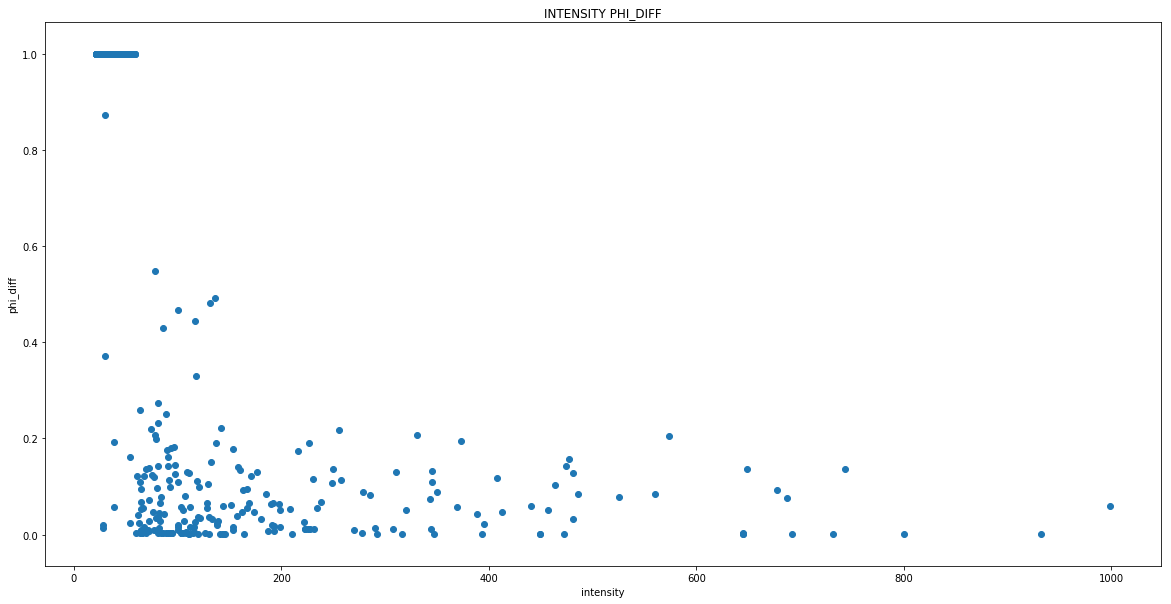

In [562]:
# Plot word intensity on x axis and phi difference on y axis on a scatterplot. 
x = phi_comparison_intenphi[:,1]
y = phi_comparison_intenphi[:,0]
fig = plt.figure()
scatterplot = fig.add_subplot(1,1,1)
plt.scatter(x,y)
fig.set_size_inches(20,10)
plt.title("INTENSITY PHI_DIFF")
plt.xlabel("intensity")
plt.ylabel("phi_diff")
plt.show()

# Gamma difference justified?

In [568]:
phi_original

[[269485, 14570, 50, 1.0],
 [269485, 13465, 50, 1.0],
 [269485, 3841, 50, 1.0],
 [269485, 27449, 50, 1.0],
 [269485, 4590, 50, 1.0],
 [269485, 5765, 50, 1.0],
 [269485, 13508, 50, 1.0],
 [269485, 26281, 50, 1.0],
 [269485, 371, 50, 1.0],
 [269485, 14902, 50, 1.0],
 [269485, 2692, 50, 1.0],
 [269485, 15607, 50, 1.0],
 [269485, 24723, 50, 1.0],
 [269485, 1534, 50, 1.0],
 [269485, 22090, 50, 1.0],
 [269485, 10240, 50, 1.0],
 [269485, 8360, 50, 1.0],
 [269485, 1158, 50, 1.0],
 [269485, 9949, 50, 1.0],
 [269485, 11009, 50, 1.0],
 [269485, 7025, 50, 1.0],
 [269485, 12759, 50, 1.0],
 [269485, 11010, 50, 1.0],
 [269485, 3852, 50, 1.0],
 [269485, 22864, 50, 1.0],
 [269485, 9178, 50, 1.0],
 [269485, 25625, 50, 1.0],
 [269485, 14979, 50, 1.0],
 [269485, 26349, 50, 1.0],
 [269485, 2287, 50, 1.0],
 [269485, 16907, 50, 1.0],
 [269485, 14218, 50, 1.0],
 [269485, 15600, 50, 1.0],
 [269485, 2216, 50, 1.0],
 [269485, 24065, 50, 1.0],
 [269485, 7073, 50, 1.0],
 [269485, 21030, 50, 1.0],
 [269485, 11713, 

In [581]:
topics_tested = np.array(output_data_theta)[:,1]
temp =[] + 
for t in topics_tested: 
    temp.append(int(t))
topics_tested = temp
print("topic", "material", "immaterial")
for topic in topics_tested: 
    topic_tested = topic
    count_material = 0
    count_immaterial = 0
    for line in phi_original: 
        if line[2] == topic_tested:
            if line[1] not in material_words_list:
                count_immaterial += 1
            else:
                count_material += 1
    print(topic_tested, count_material, count_immaterial)

('topic', 'material', 'immaterial')
(432, 1, 0)
(475, 2, 0)
(50, 385, 431)


In [586]:
print(385+431)
len(corpus_dict['0'])


816


820